In [ ]:
from elasticsearch import Elasticsearch
import pandas as pd
from datetime import timedelta
import ollama
import os
import glob

## Buscando por logs ocorridos nos timestamps

In [ ]:
# Conexão com o elasticsearch
es = Elasticsearch(
    "http://192.168.56.102:9200",
    basic_auth=("elastic", "123456")
)

atomicData = pd.read_csv('data\\logs_malicious.csv')
safeData = pd.read_csv('data\\logs_safe.csv')
atomicData = atomicData.drop('IP Address', axis=1)

# Conversão de Series para timestamp e adição do tempo final
atomicData['Execution Time (UTC)'] = pd.to_datetime(atomicData['Execution Time (UTC)'], format="%Y-%m-%dT%H:%M:%SZ")
atomicData['Execution Time End (UTC)'] = atomicData['Execution Time (UTC)'] + timedelta(seconds=5)

safeData['Execution Time (UTC)'] = pd.to_datetime(safeData['Execution Time (UTC)'], format="%Y-%m-%dT%H:%M:%SZ")
safeData['Execution Time End (UTC)'] = pd.to_datetime(safeData['Execution Time End (UTC)'], format="%Y-%m-%dT%H:%M:%SZ")

geralData = pd.concat([atomicData, safeData])
display(geralData)

for index, row in geralData.iterrows():
    query = {
        "size": 100,
        "_source": [
            "@timestamp",
            "process.name",
            "process.command_line",
            "process.parent.name",
            "process.parent.command_line",
            "file.path",
            "winlog.task"
        ],
        "query": {
            "bool": {
                "must": [
                    {
                        "range": {
                            "@timestamp": {
                                "gte": row['Execution Time (UTC)'],
                                "lte": row['Execution Time End (UTC)']
                            }
                        }
                    },
                    {
                        "bool": {
                            "should": [
                                {"exists": {"field": "process.parent.name"}},
                                {"exists": {"field": "process.parent.command_line"}},
                                {"exists": {"field": "file.path"}}
                            ],
                            "minimum_should_match": 1
                        }
                    }
                ]
            }
        }
    }

    response = es.search(index="winlogbeat-*", body=query)
    events = [hit["_source"] for hit in response["hits"]["hits"]]
    
    # Salvando dados de eventos em data/events/{timestamp}.csv
    pd_events = pd.DataFrame(events)
    pd_events.to_csv(f'data/events/{row['Execution Time (UTC)'].strftime("%Y%m%d_%H%M%S")}.csv', index=False)

,Execution Time (UTC),Execution Time (Local),Technique,Test Number,Test Name,Hostname,Username,GUID,ProcessId,ExitCode,Execution Time End (UTC)
0,2025-03-26 17:12:22,2025-03-26T14:12:22Z,T1078.001,1.0,Enable Guest account with RDP capability and a...,WIN-NTAE0RPROG5,win-ntae0rprog5\administrator,99747561-ed8d-47f2-9c91-1e5fde1ed6e0,6264.0,0.0,2025-03-26 17:12:27
1,2025-03-26 17:12:27,2025-03-26T14:12:27Z,T1078.001,2.0,Activate Guest Account,WIN-NTAE0RPROG5,win-ntae0rprog5\administrator,aa6cb8c4-b582-4f8e-b677-37733914abda,5576.0,0.0,2025-03-26 17:12:32
2,2025-03-26 17:12:33,2025-03-26T14:12:33Z,T1078.003,1.0,Create local account with admin privileges,WIN-NTAE0RPROG5,win-ntae0rprog5\administrator,a524ce99-86de-4db6-b4f9-e08f35a47a15,2760.0,0.0,2025-03-26 17:12:38
3,2025-03-26 17:12:39,2025-03-26T14:12:39Z,T1485,1.0,Windows - Overwrite file with SysInternals SDe...,WIN-NTAE0RPROG5,win-ntae0rprog5\administrator,476419b5-aebf-4366-a131-ae3e8dae5fc2,4704.0,0.0,2025-03-26 17:12:44
4,2025-03-26 17:12:45,2025-03-26T14:12:45Z,T1486,5.0,PureLocker Ransom Note,WIN-NTAE0RPROG5,win-ntae0rprog5\administrator,649349c7-9abf-493b-a7a2-b1aa4d141528,6808.0,0.0,2025-03-26 17:12:50
5,2025-03-26 17:12:51,2025-03-26T14:12:51Z,T1204.002,1.0,OSTap Style Macro Execution,WIN-NTAE0RPROG5,win-ntae0rprog5\administrator,8bebc690-18c7-4549-bc98-210f7019efff,2824.0,0.0,2025-03-26 17:12:56
6,2025-03-26 17:13:02,2025-03-26T14:13:02Z,T1059,1.0,AutoIt Script Execution,WIN-NTAE0RPROG5,win-ntae0rprog5\administrator,a9b93f17-31cb-435d-a462-5e838a2a6026,6652.0,0.0,2025-03-26 17:13:07
7,2025-03-26 17:13:08,2025-03-26T14:13:08Z,T1566.001,1.0,Download Macro-Enabled Phishing Attachment,WIN-NTAE0RPROG5,win-ntae0rprog5\administrator,114ccff9-ae6d-4547-9ead-4cd69f687306,6860.0,0.0,2025-03-26 17:13:13
8,2025-03-26 17:13:16,2025-03-26T14:13:16Z,T1566.002,1.0,Paste and run technique,WIN-NTAE0RPROG5,win-ntae0rprog5\administrator,bc177ef9-6a12-4ebc-a2ec-d41e19c2791d,2556.0,0.0,2025-03-26 17:13:21
0,2025-03-28 19:41:27,NaN,NaN,NaN,Github (Git clone repositorio legitimo),NaN,NaN,NaN,NaN,NaN,2025-03-28 19:41:29


## Ofuscando Dados

In [ ]:
import glob
import os
import pandas as pd

substituicoes = {
    "powershell.exe": "ps_script.exe",
    "Phishing": "abcoa",
    "MalDoc": "Daaoc",
    "ExternalPayloads": "Pasta1",
    "administrators": "admin",
    "cmd.exe": "command.exe",
    "net.exe": "network_tool.exe",
    "Password123!": "Pass!@#2025",
    "guest": "Ronald",
    "Remote Desktop Users": "RDP_Users",
    "Administrators": "Admins",
    r"hklm\\system\\CurrentControlSet\\Control\\Terminal Server": r"registry_path\\TerminalConfig",
    "fDenyTSConnections": "disableTS",
    "AllowTSConnections": "enableTS",
    "redcanaryco": "RuaasSyaco",
    "atomic-red-team": "project_teste",
    "AtomicRedTeam": "PojectTeste",
    "atomic":"testes",
    r"T\d{4}\.\d{3}":"12311", # CÓDIGO MITRE ATTACK
    r"T\d{4}":"12311"
}

csv_files = glob.glob(f"data\\events\\*.csv")
for file in csv_files:
    alert = pd.read_csv(file)
    
    # Substitui as palavras nas colunas relevantes
    alert['process'] = alert['process'].replace(substituicoes, regex=True)
    alert_random = alert.sample(frac=1).reset_index(drop=True)
    # Salva as alterações de volta no arquivo CSV
    file_name = os.path.basename(file)
    alert_random.to_csv(f'data\\obfuscated_events\\{file_name}', index=False)
    print(f"Arquivo {file} processado com sucesso.")

## Inferência do Ollama

In [ ]:
CSV_DIR = "data\\obfuscated_events"
MODEL = "llama3.2:3b"
MODEL_PATH = "llama3.2_3b"

csv_files = glob.glob(f"{CSV_DIR}\\*.csv")

for i in range(10):
    results = []
    for file in csv_files:
        alert = pd.read_csv(file)

        # Enviando os logs para o modelo
        response = ollama.chat(model=MODEL, messages=[
            {"role": "system", "content": "You are a cybersecurity expert specialized in analyzing system logs to identify potential attacks. Your task is to classify the set of log events as 'MALICIOUS' or 'SAFE'."},
            {"role": "system", "content": "The response should strictly be either 'MALICIOUS' or 'SAFE', with no additional explanation or context."},
            {"role": "user", "content": f"Here are the logs:\n{alert.to_json(orient='records', lines=True)}."}
        ],options={"max_tokens": 60})
        
        analysis = response['message']['content'].strip()
        results.append({"file": file, "analysis": analysis})

    # Convertendo a lista de resultados para um DataFrame
    results_df = pd.DataFrame(results)
    display(results_df)
    # Salvando os resultados em um CSV
    dir_path = f"data/inferences/{MODEL_PATH}"
    os.makedirs(dir_path, exist_ok=True)
    results_df.to_csv(f"{dir_path}/inf{i}.csv", index=False)

    print(f"Inferencia {i} salva.")

## Inferência da OpenAI

In [ ]:
import openai
import time
import glob
import os
from dotenv import load_dotenv

CSV_DIR = "data\\obfuscated_events"
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_KEY')

client = openai.OpenAI(api_key=OPENAI_API_KEY)
csv_files = glob.glob(f"{CSV_DIR}\\*.csv")

for i in range(10):
    results = []
    for file in csv_files:
        alert = pd.read_csv(file)
        alert.drop('')
        response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a cybersecurity expert specialized in analyzing system logs to identify potential attacks. Your task is to classify the set of log events as 'MALICIOUS' or 'SAFE'."},
            {"role": "system", "content": "The response should strictly be either 'MALICIOUS' or 'SAFE', with no additional explanation or context."},
            {"role": "user", "content": f"Here are the logs:\n{alert.to_json(orient='records', lines=True)}."}
        ],
        max_tokens=100
        )
        
        analysis = response.choices[0].message.content
        results.append({"file": file, "analysis": analysis})
        time.sleep(0.5)

    results_df = pd.DataFrame(results)

    dir_path = "data/inferences/gpt-4o-mini"
    os.makedirs(dir_path, exist_ok=True)
    results_df.to_csv(f"{dir_path}/inf{i}.csv", index=False)

    print(f"Inferencia {i} salva.")

## Gráfico da acurácia e F1-Score 

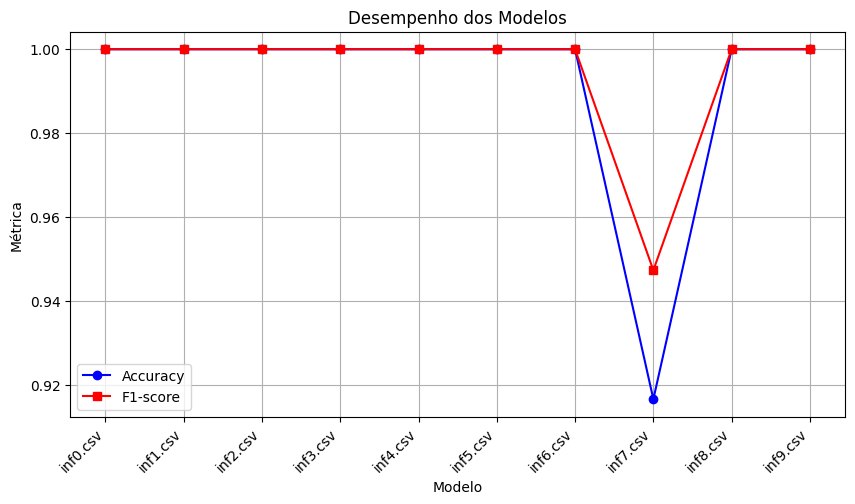

In [ ]:
import pandas as pd
import glob
import os
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Caminhos dos arquivos
real_file = "C:/Users/lucas/Documents/ic-lab/data/real_values.csv"
predictions_path = "C:/Users/lucas/Documents/ic-lab/data/inferences/gpt-4o-mini/*.csv"

# Carregar dados reais
real_data = pd.read_csv(real_file)
real_labels = real_data.set_index("file")["analysis"]

# Carregar previsões
def load_predictions(path):
    files = glob.glob(path)
    all_predictions = {}
    for file in files:
        df = pd.read_csv(file)
        predictions = df.set_index("file")["analysis"]
        all_predictions[os.path.basename(file)] = predictions
    return all_predictions

predictions = load_predictions(predictions_path)

# Calcular métricas para cada conjunto de previsões
accuracy_scores = []
f1_scores = []
labels = []

for model, pred in predictions.items():
    pred = pred.reindex(real_labels.index)  # Garantir alinhamento
    acc = accuracy_score(real_labels, pred)
    f1 = f1_score(real_labels, pred, pos_label="MALICIOUS")
    accuracy_scores.append(acc)
    f1_scores.append(f1)
    labels.append(model)

# Criar gráfico
plt.figure(figsize=(10, 5))
plt.plot(labels, accuracy_scores, marker='o', label='Accuracy', linestyle='-', color='blue')
plt.plot(labels, f1_scores, marker='s', label='F1-score', linestyle='-', color='red')
plt.xlabel("Modelo")
plt.ylabel("Métrica")
plt.title("Desempenho do Modelo")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid()
plt.show()
